<a href="https://colab.research.google.com/github/BhekiMabheka/Data_Driven_Competions/blob/master/Mall_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mall Customer Segmentation - Market Basket Analysis**

**Problem Statement**

You own the mall and want to understand the customers like who can be easily converge so that the sense can be given to marketing team and plan the strategy accordingly.

**Content**

You are owing a supermarket mall and through membership cards , you have some basic data about your customers like Customer ID, age, gender, annual income and spending score. Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.



In [1]:
%matplotlib notebook
import seaborn as sns
from sklearn import mixture
import scipy.stats as ss
from datetime import datetime
import numpy as np
import scipy as sp
from collections import Counter
import pandas as pd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from sklearn import preprocessing
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/BhekiMabheka/Data/master/Mall_Customers.csv")
df.columns  = ['cust_id', 'gender', 'age', 'annual_income', 'speding_score']
df.head()

,cust_id,gender,age,annual_income,speding_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
X = df.drop(axis = 1, labels = ['cust_id', 'gender'])
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [4]:
k_number = 4

gmm = mixture.BayesianGaussianMixture(n_components = k_number,
                                      covariance_type='full',
                                      weight_concentration_prior_type = "dirichlet_distribution",
                                      weight_concentration_prior      = 1,   
                                      max_iter=1500,
                                      random_state=0).fit(X_scaled)
gmm

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1500, mean_precision_prior=None,
                        mean_prior=None, n_components=4, n_init=1,
                        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=1,
                        weight_concentration_prior_type='dirichlet_distribution')

In [5]:
print("BGMM weight distribution: {}".format(gmm.weights_))
print("BGMM means vector: {}".format(gmm.means_))
print("BGMM covars matrix: {}".format(gmm.covariances_))
print("BGMM lower bound: {}".format(gmm.lower_bound_))
print("BGMM mean precision vector: {}".format(gmm.mean_precision_))
print("BGMM converged: {}".format(gmm.converged_))
print("BGMM number of iterations: {}".format(gmm.n_iter_))

BGMM weight distribution: [0.16656328 0.27329081 0.36191006 0.19823586]
BGMM means vector: [[ 0.37849064  1.0123323  -1.13382969]
 [-1.01095651 -0.54965043  0.30584078]
 [ 0.82456802 -0.57203332 -0.36224143]
 [-0.4296749   0.95150111  1.19236617]]
BGMM covars matrix: [[[ 0.34766116 -0.07526868 -0.02239903]
  [-0.07526868  0.47446532 -0.05726444]
  [-0.02239903 -0.05726444  0.2470842 ]]

 [[ 0.16618752 -0.04463342  0.04044504]
  [-0.04463342  0.535231   -0.51685456]
  [ 0.04044504 -0.51685456  0.71771478]]

 [[ 0.77036197  0.15033829  0.08952456]
  [ 0.15033829  0.34420923  0.25880311]
  [ 0.08952456  0.25880311  0.38804694]]

 [[ 0.09394126 -0.03028354 -0.01151241]
  [-0.03028354  0.41237315  0.03531825]
  [-0.01151241  0.03531825  0.19264385]]]
BGMM lower bound: -227.75795960184573
BGMM mean precision vector: [33.97890816 55.75132561 73.82965142 40.4401148 ]
BGMM converged: True
BGMM number of iterations: 14


In [6]:
df['cluster'] = gmm.predict(X_scaled)
cluster_probs = gmm.predict_proba(X_scaled)

for i in range(k_number):
    df['c_{}'.format(i)] = cluster_probs[:, i]

In [7]:
def apply_entropy_calc(row):
    """
    Calculate entropy.
    """
    return ss.entropy(row, base=k_number)

In [8]:
df['entropy'] = df.loc[:, 'c_0':'c_{}'.format(k_number - 1)].apply(apply_entropy_calc, axis=1)
print("Mean entropy of weight distributions: {}".format(df['entropy'].mean()))

Mean entropy of weight distributions: 0.08225472669073473


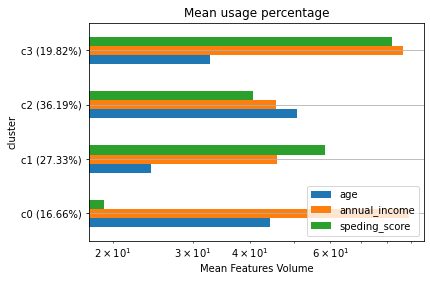

In [9]:
cluster_label = ["{} ({:.2f}%)".format(c, w*100) for c, w in zip(['c0', 'c1', 'c2', 'c3'], gmm.weights_)]
df[['age',
   'annual_income',
   'speding_score',
   'cluster']].groupby('cluster').mean().plot.barh()

plt.title("Mean usage percentage"),plt.yticks([0, 1, 2, 3], cluster_label)
plt.grid(), plt.xlabel("Mean Features Volume"), plt.xscale('log');

**Correlation Matrix**

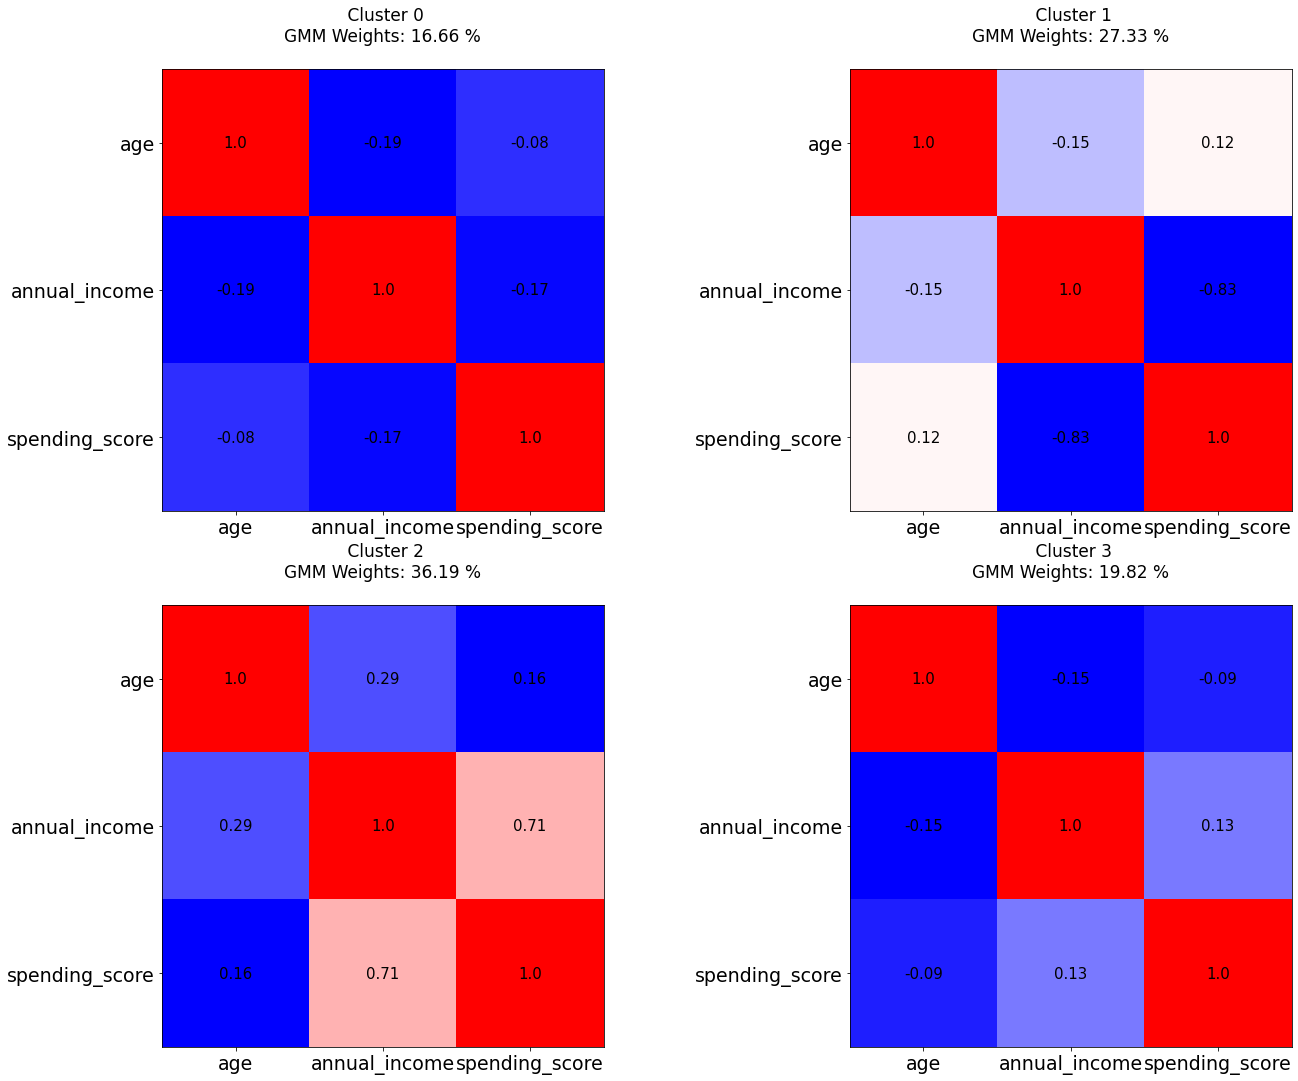

In [12]:
covars = gmm.covariances_
# gmm_weights = gmm.weights_

def corr_from_covar(covar):
    v = np.sqrt(np.diag(covar))
    outer_v = np.outer(v, v)
    corr = covar / outer_v
    corr[covar == 0] = 0
    return corr

scaler.inverse_transform(gmm.means_)

# plot the covar/corr matrices
fig, axs = plt.subplots(2, 2, figsize=(20, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()
 
for i in range(k_number):
    
    columns = ['age', 'annual_income', 'spending_score']
    
    corr = corr_from_covar(covars[i])
    gmm_weights = gmm.weights_ * 100
    gmm_weights = list(np.round(gmm_weights, 2))
    
    cax = axs[i].matshow(corr, cmap='bwr', interpolation ='None')
    
    #axs[i].set_ylabel("Cluster {}".format(i))
    axs[i].set_xticks(np.arange(len(columns)))
    axs[i].xaxis.set_ticks_position('bottom')
    axs[i].set_yticks(np.arange(len(columns)))
    
    axs[i].set_yticklabels(columns, fontsize = 19)
    axs[i].set_xticklabels(columns, fontsize = 19)
    axs[i].set_title(" Cluster {}\nGMM Weights: {} %".format(i, gmm_weights[i]), fontsize = 17)
    
      
    #Annote the correlation matrix 
    kw = dict(horizontalalignment="center",
              verticalalignment="center",
             fontsize = 15)
           
    for z in range(len(columns)):
        for j in range(len(columns)):
            text = axs[i].text(j, z, corr[z, j].round(2), **kw)

                     
plt.tight_layout(pad=0.8)
plt.show()